In [1]:
card_name = 'Cat_q2var_test'

In [2]:
fit_real_data = True

# Import

In [3]:
import sys, os
from glob import glob
sys.path.append('../lib')
import itertools

In [4]:
import numpy as np
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import plot_gridVarQ2

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "Preliminary"
else:
    CMS_lumi.extraText = "Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Create histograms file

In [5]:
file_loc = {
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root'
}
if fit_real_data:
    file_loc['data'] = '../data/cmsRD/Run2018D/B02DstMu_19*_BPH*.root'

branches = ['q2', 'Est_mu', 'M2_miss',
            'mass_MuDst', 'cos_MuDst_vtxBest'
           ]

dSet = {}
for k, fn in file_loc.iteritems():
    dSet[k] = extarct_multiple(fn, branches=branches, flag=k)
    print k, ':', dSet[k]['Est_mu'].shape[0], 'candidates'

mu : 15963 candidates
tau : 7222 candidates
data : 323091 candidates


In [6]:
analysis_selection = {
'mass_MuDst'      : ['<', 5.280],
'cos_MuDst_vtxBest' : ['>', 0.98]
}

binning = {
    'q2'      : [4, -2, 10.7],
    'M2_miss' : [40/2, -5, 10],
    'Est_mu'  : [30/2, 0.10, 2.500]
}

In [9]:
histo = {}
for i_q2 in range(binning['q2'][0]):
    w_q2 = (binning['q2'][2] - binning['q2'][1])/binning['q2'][0]
    q2_l = binning['q2'][1] + w_q2 * i_q2
    q2_h = binning['q2'][1] + w_q2 * (i_q2+1)

    for var in ['M2_miss', 'Est_mu']:
        cat_name = var+'_q2-'+str(i_q2)
        histo[cat_name] = {}
        for k in file_loc.keys():
            d = dSet[k]
            an_sel = createSel(d, analysis_selection)
            q2_sel = np.logical_and(d['q2'] > binning['q2'][1], d['q2'] < binning['q2'][2])
            q2_bin = np.logical_and(d['q2'] > q2_l, d['q2'] < q2_h)
            
            global_sel = np.logical_and(an_sel, q2_sel)
            sel = np.logical_and(global_sel, q2_bin)
            
            histo[cat_name][k] = create_TH1D(d[var][sel], 
                                             name=k, title=k,
                                             binning=binning[var],
                                             opt='underflow,overflow'
                                            )
            if not k == 'data':
                histo[cat_name][k].Scale(1./float(np.sum(global_sel)))

Generate Pseudo-data

In [11]:
if fit_real_data:
    rawR_inj = 0.2
    N_exp = 0
    N_mu = 0
    N_tau = 0
    for k, h_dic in histo.iteritems():
        if 'Est_mu' in k:
            N_exp += h_dic['data'].Integral()
            N_mu += h_dic['mu'].Integral()
            N_tau += h_dic['tau'].Integral()
    N_B2mu_inj = N_exp/(1+rawR_inj)
    print N_exp
    print N_mu
    print N_tau
else:    
    rawR_inj = 0.2
    N_B2mu_inj = 5000

    an_sel_mu = createSel(dSet['mu'], analysis_selection)
    n_mu = np.random.poisson(lam=N_B2mu_inj)
    idx_mu = np.random.randint(0, np.sum(an_sel_mu), size=(n_mu, ))

    an_sel_tau = createSel(dSet['tau'], analysis_selection)
    n_tau = np.random.poisson(lam=N_B2mu_inj*rawR_inj)
    idx_tau = np.random.randint(0, np.sum(an_sel_tau), size=(n_tau, ))

    pseudo_data = {}
    for var in binning.keys():
        pseudo_data[var] = np.concatenate((dSet['mu'][var][an_sel_mu][idx_mu], 
                                           dSet['tau'][var][an_sel_tau][idx_tau]
                                          ))

    for i_q2 in range(binning['q2'][0]):
        w_q2 = (binning['q2'][2] - binning['q2'][1])/binning['q2'][0]
        q2_l = binning['q2'][1] + w_q2 * i_q2
        q2_h = binning['q2'][1] + w_q2 * (i_q2+1)

        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2-'+str(i_q2)

            sel = np.logical_and(pseudo_data['q2'] > q2_l, pseudo_data['q2'] < q2_h)

            histo[cat_name]['data'] = create_TH1D(pseudo_data[var][sel], 
                                             name='dataObs', title='data obs',
                                             binning=binning[var],
                                             opt='underflow,overflow'
                                            )

    print n_mu, n_tau
    print 'r_toy = {:.2f}%'.format(100.*n_tau/n_mu)

316427.0
1.0
1.0


In [12]:
histo_file_dir = '../data/_root/histos4combine/'
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()

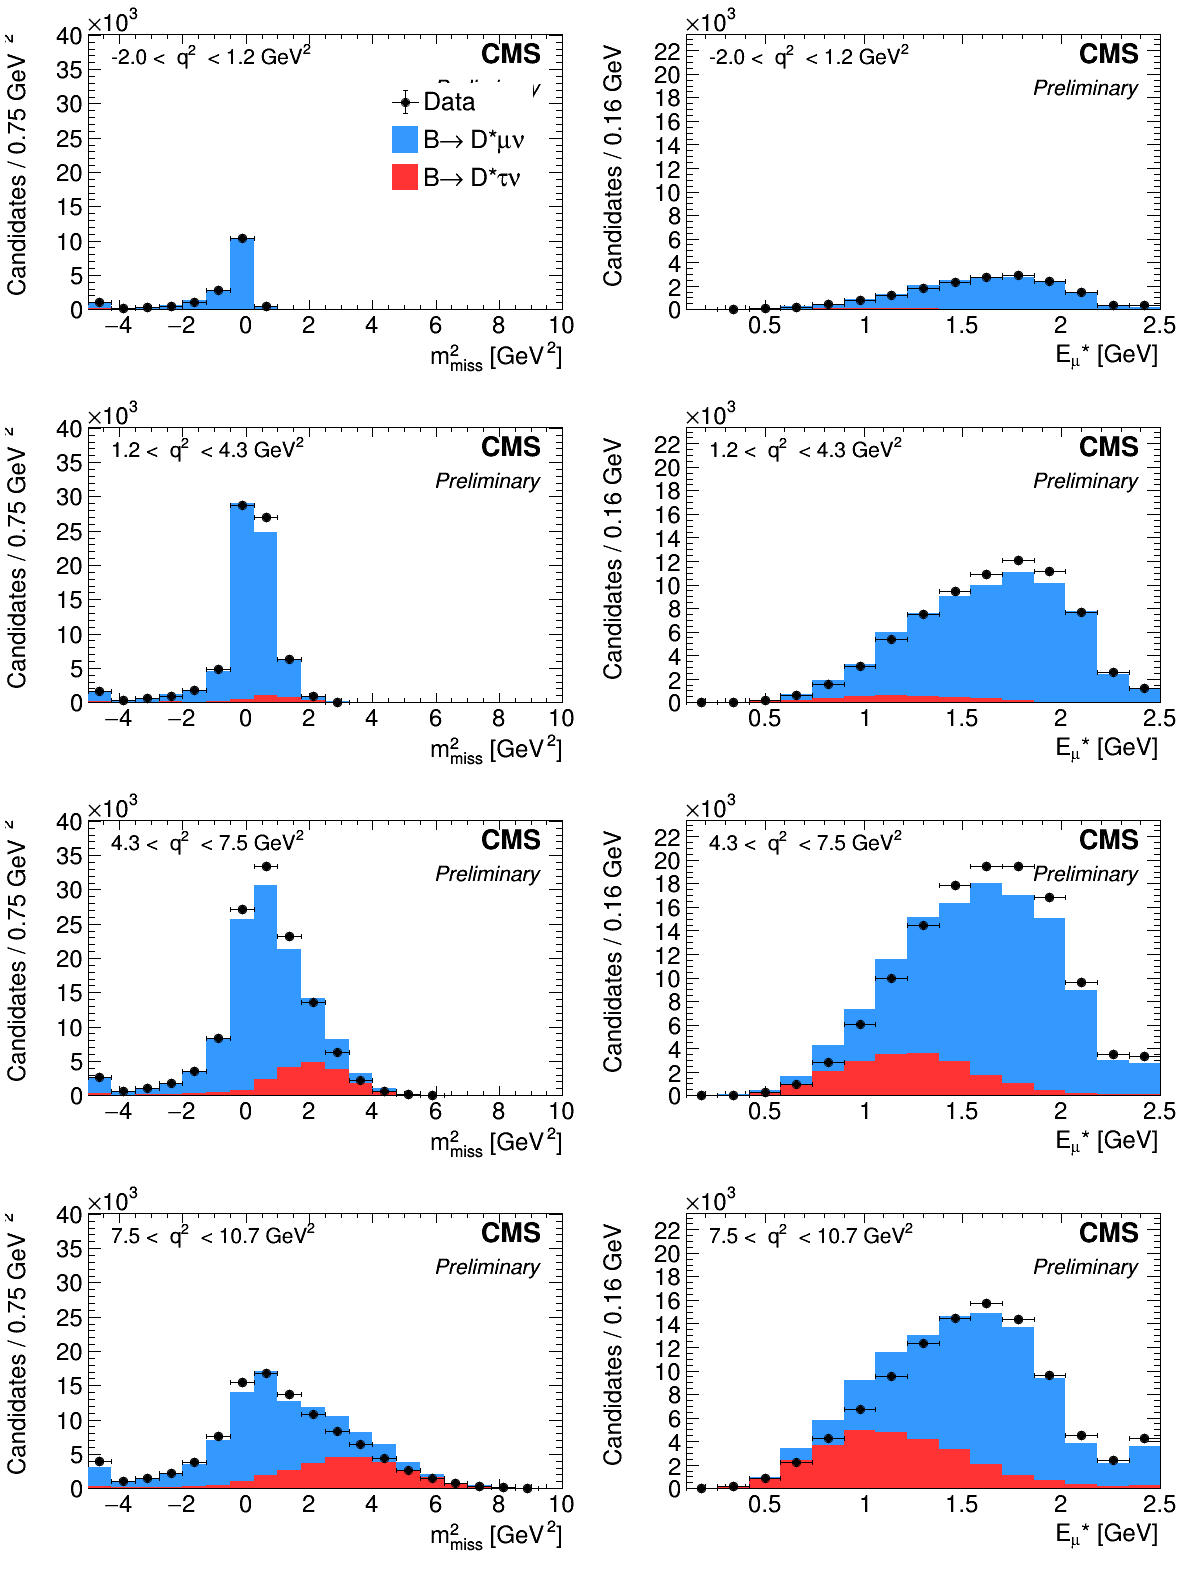

In [13]:
scale_dic = {'tau':N_B2mu_inj*rawR_inj, 
             'mu':N_B2mu_inj}

c = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic)

# Write the card

In [55]:
sig_processes = ['tau', 'mu']
bkg_processes = []
processes = sig_processes + bkg_processes
categories = np.sort(histo.keys())

In [56]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [57]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '-------------------------------\n'

In [58]:
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += '-------------------------------\n'

In [59]:
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += '-------------------------------\n'

In [60]:
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += '-------------------------------\n'

Add additional rate parameters

In [61]:
card += 'N_B2mu rateParam * tau {}\n'.format(N_B2mu_inj)
card += 'N_B2mu rateParam * mu {}\n'.format(N_B2mu_inj)
card += '-------------------------------\n'

MC statistic systematics

In [62]:
card += '* autoMCStats 99999999 1 1\n'
card += '-------------------------------\n'

In [63]:
print card

imax *
jmax 1
kmax *
-------------------------------
shapes * Est_mu_q2-0 ../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-1 ../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-2 ../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-3 ../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-3.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-0 ../data/_root/histos4combine/Cat_q2var_test_M2_miss_q2-0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-1 ../data/_root/histos4combine/Cat_q2var_test_M2_miss_q2-1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-2 ../data/_root/histos4combine/Cat_q2var_test_M2_miss_q2-2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-3 ../data/_root/histos4combine/Cat_q2var_test_M2_miss_q2-3.root $PROCESS $PROCESS__$SYSTEMATIC
-------------------------------
bin

In [64]:
fc.write(card)
fc.close()

### Create output directory

In [65]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir);

# Run Combine

### Run the Maximum Likelyhood fit

In [66]:
cmd = 'combine'
cmd += ' -M FitDiagnostics'
cmd += ' --robustFit 1'
cmd += ' --skipBOnlyFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties'
cmd += ' --plots'
cmd += ' --verbose 0'

In [67]:
print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')

combine -M FitDiagnostics --robustFit 1 --skipBOnlyFit -d cards/Cat_q2var_test.txt -D data --X-rtd MINIMIZER_analytic --setParameters r=0.1 --setParameterRanges r=0.001,1 --trackParameters N_B2mu -n Cat_q2var_test --out results/Cat_q2var_test --saveShapes --saveWithUncertainties --plots --verbose 0


0

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Channel Est_mu_q2-0 will use autoMCStats with settings: event-threshold=1e+08, include-signal=1, hist-mode=1
Analysing bin errors for: prop_binEst_mu_q2-0
Poisson cut-off: 1e+08
Bin        Contents        Error           Notes                         
0          0.000527        0.000000        total sum                     
  => Error is zero, ignore      
------------------------------------------------------------
1          36.993695       36.993430       total sum                     
1          1.000000        1.000000        Unweighted events, alpha=36.993695
  => Number of weighted events is below poisson threshold
    mu                   0.000000        0.000000                                      
      => Error is zero, ignore      
  ----------------------------------

Channel Est_mu_q2-0 has bin 2 fill in data but empty in all backgrounds
Channel Est_mu_q2-1 has bin 1 fill in data but empty in all backgrounds
Channel Est_mu_q2-1 has bin 2 fill in data but empty in all backgrounds
Channel Est_mu_q2-2 has bin 1 fill in data but empty in all backgrounds
Channel Est_mu_q2-3 has bin 1 fill in data but empty in all backgrounds
Channel M2_miss_q2-2 has bin 15 fill in data but empty in all backgrounds
Channel M2_miss_q2-3 has bin 18 fill in data but empty in all backgrounds
Channel M2_miss_q2-3 has bin 19 fill in data but empty in all backgrounds
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-fkIPbW.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Error in <RooFormula::Compile>:  Bad numerical expression : "CMS_channel::Est_mu_q2"
Error in <RooFormula::Compile>:  Bad numerical expression : "CMS_channel::Est_mu_q2"
Error in <RooFormula::Compile>:  Bad numerical expression : 

r = 0.093 +0.004/-0.004
N_B2mu = 289699


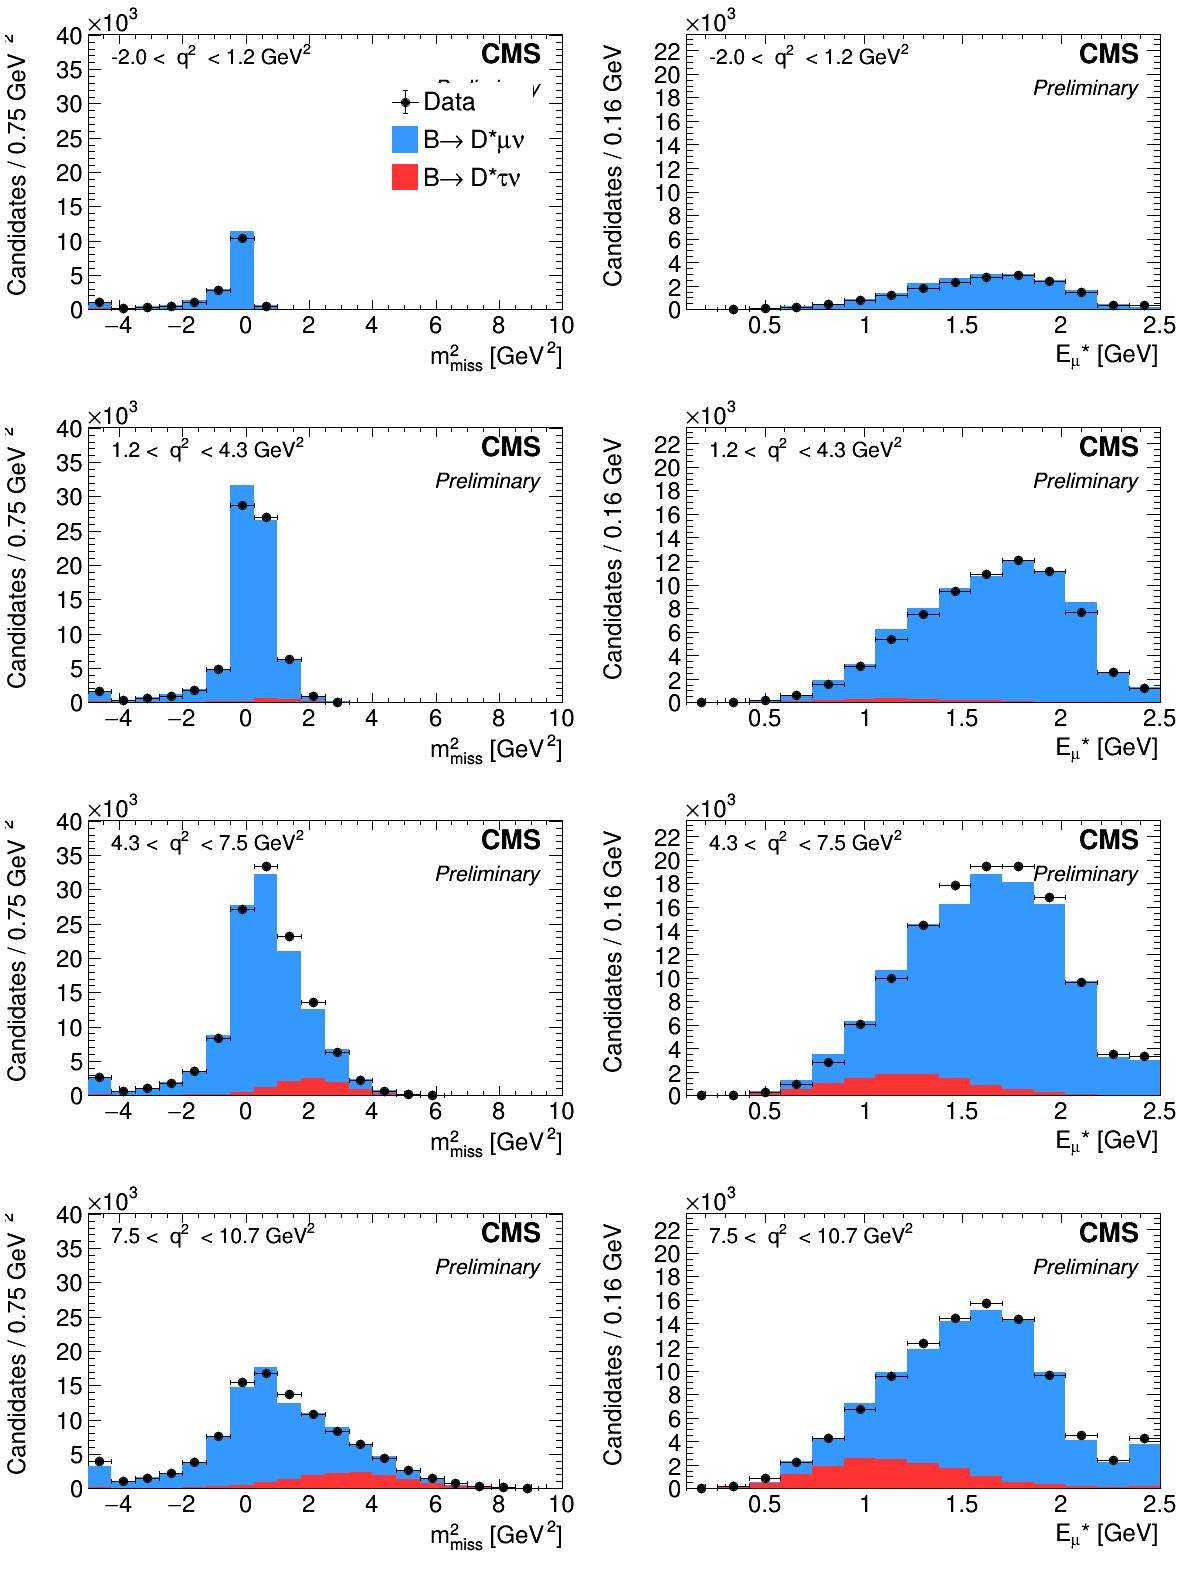

In [68]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.root'.format(card_name))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'r = {:.3f} +{:.3f}/-{:.3f}'.format(c, u-c, c-d)

N_B2mu = f['limit']['trackedParam_N_B2mu'].array()[0]
print 'N_B2mu = {:.0f}'.format(N_B2mu)

scale_dic = {'tau':N_B2mu*c, 
             'mu':N_B2mu}

c = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic)

### Run the Goodness of fit test

Run the observed test stat value

In [ ]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 9'

In [ ]:
print cmd
os.system(cmd)

Run the test stat toy distribution

In [ ]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 300'                                    # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
# cmd += '--expectSignal=0'                           # Depending on the hypothesis to test. If none, r is fluctruated
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 1'

In [ ]:
print cmd
os.system(cmd)

Combine them to get the p-value

In [ ]:
name_obs = glob('higgsCombineObs.GoodnessOfFit.*.root')[0]
name_toys = glob('higgsCombineToys.GoodnessOfFit.*.root')[0]

In [ ]:
f = ur.open(name_obs)
s_obs = f['limit']['limit'].array()[0]

f = ur.open(name_toys)
s_toys = f['limit']['limit'].array()

p_val = np.sum(s_toys > s_obs)/float(s_toys.shape[0])
print 'p-value: {:.1f}%'.format(100*p_val)
if p_val < 0.01: print p_val

In [ ]:
# cmd = 'combineTool.py'
# cmd += ' -M CollectGoodnessOfFit'
# cmd += ' --mass 120'
# cmd += ' -o gof.json'
# cmd += ' --input {} {}'.format(name_obs, name_toys)
# print cmd
# os.system(cmd)
# os.system('plotGof.py gof.json -o gof --mass 120.0')

In [ ]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv *.dot {}/'.format(outdir))
os.system('mv *.out {}/'.format(outdir))